### Judul project: Sistem Klasifikasi Sampah dalam Mendukung Pengelolaan Limbah

## Setelah pre-processing

#### Nama Anggota Kelompok:
1. GEVANO KEVIN RAVENSY (F1D022121)
2. NAZILA IMKANI (F1D022084)
3. QHAULAN SYAQHILA (F1D022152)
4. ADHYATMIKA EKA SAPUTRA (F1D022105)

In [2]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
from rembg import remove
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


Kode di atas mengimpor library Python yang digunakan untuk pemrosesan citra, analisis data, dan machine learning. Library seperti os dan cv2 digunakan untuk mengelola file dan memproses gambar. numpy dan pandas digunakan untuk manipulasi data, sedangkan math digunakan untuk operasi matematika. tqdm menyediakan progress bar untuk loop, dan rembg digunakan untuk menghapus latar belakang gambar. seaborn dan matplotlib digunakan untuk visualisasi data. Model pembelajaran mesin seperti SVM (SVC), KNN (KNeighborsClassifier), dan Random Forest (RandomForestClassifier) diimpor dari sklearn, bersama dengan alat bantu seperti SimpleImputer untuk menangani nilai hilang, StandardScaler untuk normalisasi, serta fungsi evaluasi seperti accuracy_score, precision_score, recall_score, f1_score, dan confusion_matrix untuk mengukur kinerja model.

In [3]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = [] 
    path = []
    data_distribution = {}
    for label in (os.listdir(folder)):
        images = os.listdir(folder+label)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(label)
        count = 0
        for filename in tqdm(os.listdir(folder+label)):
            if count == 100:
                break
            else :
                count += 1
            img = cv.imread(os.path.join(folder+label,filename))
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                
                filenames.append(filename)
                path.append(label)
                data.append(img)
    return data, filenames, datalabel, path , data_distribution

Fungsi insertGambar membaca gambar dari folder yang berisi subfolder dengan label berbeda. Gambar-gambar tersebut dikonversi ke format RGB dan disimpan dalam daftar bersama dengan nama file dan labelnya. Fungsi ini juga membatasi jumlah gambar yang diambil per label hingga 100 dan menghitung distribusi data untuk setiap label. Hasilnya adalah kumpulan data gambar, nama file, label, jalur label, dan distribusi data.

In [4]:
images, filenames,labels, path, distribusi = insertGambar("dataset/") 
print("Data: ", len(images))
print("Label: ", len(labels))
print("Filenames: ", len(filenames))
print("Data Distribution: ", distribusi)

paper


100%|██████████| 100/100 [00:00<00:00, 492.13it/s]


plastic


100%|██████████| 100/100 [00:00<00:00, 582.91it/s]


trash


100%|██████████| 100/100 [00:00<00:00, 521.01it/s]

Data:  300
Label:  3
Filenames:  300
Data Distribution:  {'paper': 100, 'plastic': 100, 'trash': 100}


Fungsi insertGambar membaca gambar dari folder "dataset/", mengembalikan data gambar, nama file, label, jalur label, dan distribusi data. Kode ini kemudian mencetak jumlah gambar, jumlah label, jumlah nama file, dan distribusi data per label.

In [5]:
def display_sample(images):
  plt.figure(figsize=(20,10))
  for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
  plt.show()    

Fungsi display_sample menampilkan sampel gambar dari daftar images menggunakan matplotlib. Fungsi ini membuat plot dengan ukuran 20x10 inci, dan menampilkan 7 gambar pertama dalam subplots yang disusun secara horizontal.

In [6]:
def removeBackground(images):
    removed_data = []
    for i in tqdm(range(len(images))):
        removed_data.append(remove(images[i]))
    return removed_data

Fungsi removeBackground menghapus latar belakang dari setiap gambar dalam daftar images menggunakan fungsi remove dari pustaka rembg, dan menampilkan progress bar dengan tqdm. Hasilnya adalah daftar removed_data yang berisi gambar-gambar yang telah dihapus backgroundnya.

100%|██████████| 300/300 [08:59<00:00,  1.80s/it]


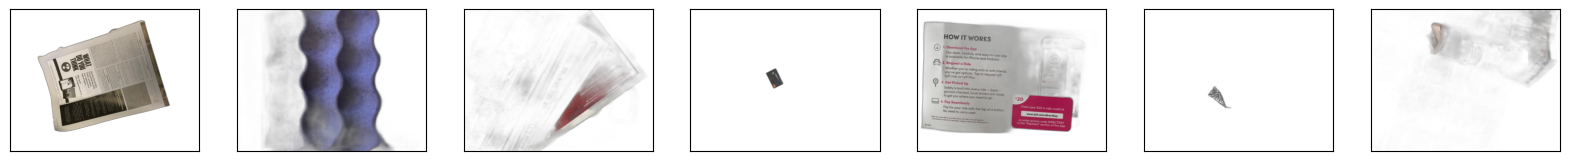

In [7]:
remove_bg = removeBackground(images)  

display_sample(remove_bg)

kode di atas menunjukkan bahwa fungsi removeBackground menghapus latar belakang dari setiap gambar dalam images dan menyimpan hasilnya dalam remove_bg. Fungsi display_sample kemudian menampilkan sampel gambar-gambar yang dihasilkan.

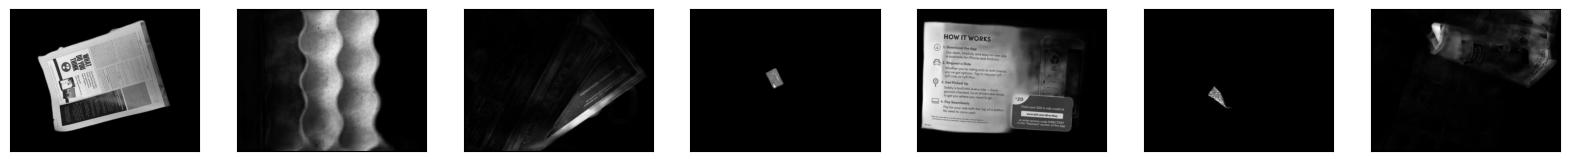

In [8]:
def gray_scaling(data):
    grayData = []
    for img in data:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        grayData.append(gray)
    return grayData

gray_img = gray_scaling(remove_bg)

display_sample(gray_img)

Fungsi gray_scaling di atas mengonversi setiap gambar dalam data menjadi grayscale dan menyimpannya dalam grayData. gray_img kemudian berisi gambar-gambar grayscale yang ditampilkan menggunakan display_sample.

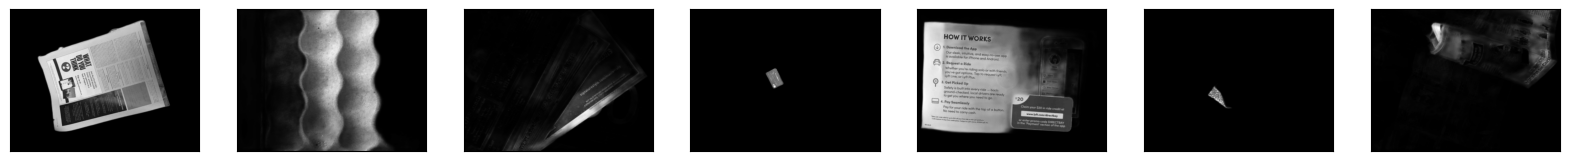

In [9]:
def normalisasi(data):
    normData = []
    for img in data:
        norm = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
        normData.append(norm)
    return normData

normData = normalisasi(gray_img)

display_sample(normData)

Fungsi normalisasi di atas menormalkan setiap gambar dalam data ke rentang nilai piksel [0, 255] dan menyimpannya dalam normData. normData kemudian berisi gambar-gambar yang dinormalisasi dan ditampilkan menggunakan display_sample.

In [10]:
def ekualisasi(img):
    histogram = np.zeros(256).astype(int)
    hImg, wImg = img.shape

    for i in range(hImg):
        for j in range(wImg):
            value = img[i, j]
            histogram[value] += 1
    
    dist_kumulatif = np.zeros(256).astype(int)
    dist_kumulatif[0] = histogram[0]
    for i in range(1, 256):
        dist_kumulatif[i] = dist_kumulatif[i-1] + histogram[i]
    
    target_value = dist_kumulatif * (256-1) / (hImg * wImg)
    target_value = np.floor(target_value).astype(int)

    result = target_value[img]
    return result

def ekualisasiData(data):
    hasil = []
    for img in data:
        gambar = ekualisasi(img)
        hasil.append(gambar)
    return hasil

Fungsi ekualisasi melakukan ekualisasi histogram pada gambar untuk meningkatkan kontras dengan menghitung distribusi kumulatif histogram dan memetakan nilai piksel. ekualisasiData menerapkan fungsi ekualisasi pada setiap gambar dalam data dan menyimpan hasilnya dalam daftar hasil.

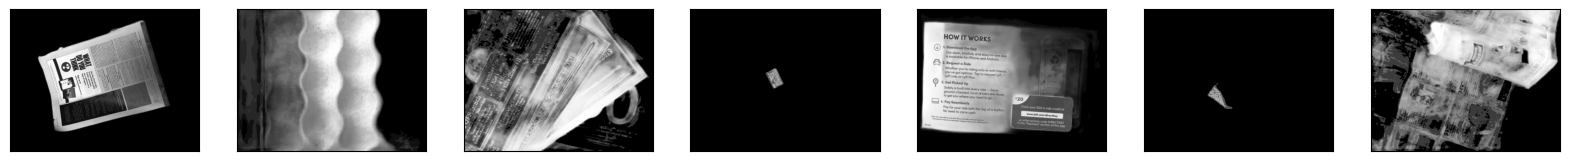

In [11]:
ekualisasiData = ekualisasiData(normData)

display_sample(ekualisasiData)

kode di atas adalah penerapan ekualiasasi data yang diikuti dengan menampilkan sample data hasil ekualisasi.

In [12]:
def meanFilter(image):
    heightImage, widthImage = image.shape
    padImage = np.pad(image, (1,1))
    kernel = np.zeros((3,3))
    result = np.zeros([heightImage, widthImage]).astype(int)
    for i in range(heightImage):
        for j in range(widthImage):
            temp = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    temp += padImage[i+k, j+l]
            result[i, j] = int(temp/(kernel.shape[0]*kernel.shape[1]))
    return result

def meanFilterData(data):
    hasil = []
    for img in tqdm(data):
        gambar = meanFilter(img)
        hasil.append(gambar)
    return hasil

Fungsi meanFilter menerapkan mean filter pada gambar untuk menghaluskan dan mengurangi noise. meanFilterData menggunakan meanFilter pada setiap gambar dalam data dan menyimpan hasilnya dalam daftar hasil.

100%|██████████| 300/300 [02:22<00:00,  2.10it/s]


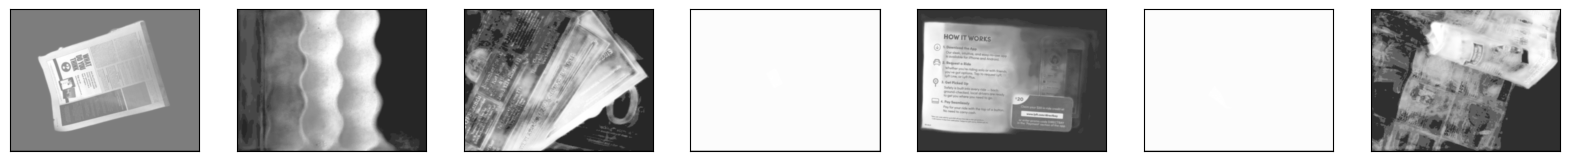

In [13]:
meanData = meanFilterData(ekualisasiData)

display_sample(meanData)

kode di atas adalah penerapan mean filter data yang diikuti dengan menampilkan sample data hasil filtering.

In [14]:
def matriksTransformasi(matriks):
    hasil = np.zeros(matriks.shape)
    for i in range(matriks.shape[0]):
        for j in range(matriks.shape[1]):
            hasil[i][j] = matriks[j][i]
    return hasil
def sum(matriks):
    hasil = 0
    for i in range(len(matriks)):
        for j in range(len(matriks[0])):
            hasil += matriks[i][j]
    return hasil

Fungsi matriksTransformasi mentranspos matriks dengan menukar baris dan kolom.

In [15]:
def derajat(img, derajat):
    max = int(np.max(img))
    temp=np.zeros([max+1,max+1])
    if derajat == 0:
        for i in range (len(img)):
            for j in range (len(img[0])-1):
                temp[img[i,j],img[i,j+1]] += 1
    elif derajat == 45:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i+1,j],img[i,j+1]] += 1
    elif derajat == 90:
        for i in range (len (img)-1):
            for j in range (len (img[0])):
                temp[img[i+1,j],img[i,j]] += 1
    elif derajat == 135:
        for i in range (len (img)-1):
            for j in range (len (img[0])-1):
                temp[img[i,j],img[i+1,j+1]] += 1
    hasil = temp+matriksTransformasi(temp)
    total = sum(hasil)
    for i in range (len (hasil)):
        for j in range (len (hasil)):
            hasil[i,j]/=total
    return hasil

Fungsi derajat menghitung matriks co-occurrence untuk gambar img pada sudut tertentu (0, 45, 90, 135 derajat). Matriks ini dihitung berdasarkan pasangan piksel pada sudut yang ditentukan, dan hasilnya dinormalisasi dengan membagi setiap elemen dengan jumlah total elemen dalam matriks.

In [16]:
def GLCM(image):
    hasil = []
    for img in tqdm(image):
        if np.min(img) < 0:
            continue
        data = []
        data.append(derajat(img,0))
        data.append(derajat(img,45))
        data.append(derajat(img,90))
        data.append(derajat(img,135))
        hasil.append(data)    
    return hasil

Fungsi GLCM menghitung matriks co-occurrence pada sudut 0, 45, 90, dan 135 derajat untuk setiap gambar dalam image dan menyimpan hasilnya dalam hasil. Jika gambar memiliki nilai negatif, gambar tersebut dilewati.

In [17]:
hasil = GLCM(meanData)

100%|██████████| 300/300 [03:02<00:00,  1.65it/s]


kode di atas adalah implementasi dari fungsi GLCM(meanData)

In [18]:
def contrast (data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*pow(i-j,2)
    return hasil
def dissimilarity(data):  
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=data[i,j]*abs(i-j)
    return hasil
def homogeneity(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil+=(data[i,j]/(1+pow(i-j,2)))
    return hasil
def energy(data):
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += data[i][j] ** 2
    return hasil
def correlation(data):
    mean = np.zeros((2))
    std = np.zeros((2))
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean[0] += i*data[i,j]
            mean[1] += j*data[i,j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std[0] += pow(i-mean[0],2)*data[i,j]
            std[1] += pow(j-mean[1],2)*data[i,j]
    std[0] = math.sqrt(std[0])
    std[1] = math.sqrt(std[1])
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i-mean[0])*(j-mean[1])*data[i,j]/(std[0]*std[1])
    return hasil
def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy
def asm(data):
    asm = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            asm += data[i][j] ** 2
    return asm

Fungsi-fungsi ini menghitung berbagai fitur tekstur dari matriks co-occurrence, termasuk kontras, dissimilarity, homogenitas, energi, korelasi, entropi, dan ASM. Masing-masing fitur memberikan informasi tentang pola dan distribusi intensitas piksel dalam gambar.

In [19]:
def ekstraksi(data):
    result = []
    for i in tqdm(range(len(data))):
        extracted_data = []
        for j in range(len(data[i])):
            contrast_val = contrast(data[i][j])
            extracted_data.append(contrast_val)
        for j in range(len(data[i])):
            dissimilarity_val = dissimilarity(data[i][j])
            extracted_data.append(dissimilarity_val)
        for j in range(len(data[i])):
            homogeneity_val = homogeneity(data[i][j])
            extracted_data.append(homogeneity_val)
        for j in range(len(data[i])):
            energy_val = energy(data[i][j])
            extracted_data.append(energy_val)
        for j in range(len(data[i])):
            correlation_val = correlation(data[i][j])
            extracted_data.append(correlation_val)
        for j in range(len(data[i])):
                asm_val = asm(data[i][j])
                extracted_data.append(asm_val)
                entropy_val = entropy(data[i][j])
                extracted_data.append(entropy_val)
        result.append(extracted_data)
    return result

Fungsi di atas mngekstraksi menghitung fitur tekstur seperti kontras, dissimilarity, homogenitas, energi, korelasi, ASM, dan entropi untuk setiap matriks co-occurrence dalam data. Hasil fitur-fitur ini kemudian disimpan dalam result.

In [20]:
hasilGLCM = ekstraksi(hasil)

100%|██████████| 300/300 [04:57<00:00,  1.01it/s]


pada code di atas didapatkan hasi GLCM

In [21]:
for i in range (len(hasilGLCM)):
    hasilGLCM[i].append(path[i])

kode di aats bertujuan  untuk menambahkan label dari path ke setiap elemen dalam hasilGLCM.

In [22]:
print((hasilGLCM[0]))

[20.298495596868896, 43.62798587727995, 24.4567456755875, 44.656185332604615, 1.169836513372469, 1.8682254116997865, 1.1532004732376, 1.8224338700035327, 0.8058533693171923, 0.7733397879194344, 0.8293003779853445, 0.7842539216300768, 0.38911662127508573, 0.38664551567029376, 0.3885124790805099, 0.3863600482422991, 0.9870278472052624, 0.9717180103866971, 0.9843151766093924, 0.9710514766072597, 0.38911662127508573, 3.251530681474982, 0.38664551567029376, 3.381998408750218, 0.3885124790805099, 3.182406960889389, 0.3863600482422991, 3.3475056657041433, 'paper']


kode di atas mencetak hasil GLM

In [23]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
headers = []
for fitur in fiturs:
    headers.extend([f'{fitur}_0', f'{fitur}_45', f'{fitur}_90', f'{fitur}_135'])
for angle in angles:
    headers.extend([f'asm_{angle}', f'entropy_{angle}'])
headers.append('Path')
df = pd.DataFrame(hasilGLCM, columns=headers)
df.to_csv('sesudahPreprocessing.csv', index=False)

kode di atas menunjukkan persiapan header kolom untuk DataFrame berdasarkan fitur tekstur dan sudut, lalu menyimpan hasilGLCM ke file CSV sesudahPreprocessing.csv.

In [24]:
df = pd.read_csv('sesudahPreprocessing.csv')
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)     

print(df)

     contrast_0  contrast_45  contrast_90  contrast_135  dissimilarity_0  \
0     20.298496    43.627986    24.456746     44.656185         1.169837   
1     10.755422    24.801546    14.594704     25.433870         1.589551   
2     39.134092    58.571194    41.057518     94.724147         3.691648   
3     27.537804    64.375928    36.766981     64.375724         0.329470   
4     21.166860    50.254071    29.150646     48.019452         1.648351   
5     27.537977    64.376705    36.767502     64.375959         0.329644   
6     29.102408    60.545738    36.876336     67.037984         2.799092   
7     35.803306    87.064523    50.133353     82.792763         2.480471   
8     19.834404    45.422951    25.095637     43.478471         0.915749   
9     96.883664   156.105057    75.274794    177.413079         4.091793   
10    32.697662    66.068835    32.883822     61.665091         2.230043   
11    18.947285    41.862227    22.824494     41.302172         0.922171   
12    62.348


Kode di atas adalah porses membaca file CSV sesudahPreprocessing.csv ke dalam DataFrame df dan mengatur opsi untuk menampilkan semua kolom dan baris dalam DataFrame. selanjutnya, Menampilkan DataFrame df dengan mencetaknya ke output.

In [25]:
from sklearn.decomposition import PCA
df = pd.read_csv('sesudahPreprocessing.csv')
x = df.drop('Path', axis=1)
y = df['Path']

pca = PCA(n_components=25)
x = pca.fit_transform(x)

kode di atas menghapus kolom 'Path' dari DataFrame untuk mendapatkan fitur x dan menyimpan label ke y. Mengaplikasikan PCA untuk mengurangi dimensi fitur x menjadi 25 komponen utama.

In [26]:
df.head(10)

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,homogeneity_90,homogeneity_135,energy_0,energy_45,energy_90,energy_135,correlation_0,correlation_45,correlation_90,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,Path
0,20.298496,43.627986,24.456746,44.656185,1.169837,1.868225,1.153200,1.822434,0.805853,0.773340,0.829300,0.784254,0.389117,0.386646,0.388512,0.386360,0.987028,0.971718,0.984315,0.971051,0.389117,3.251531,0.386646,3.381998,0.388512,3.182407,0.386360,3.347506,paper
1,10.755422,24.801546,14.594704,25.433870,1.589551,2.011992,1.056906,2.058949,0.616287,0.580490,0.699150,0.569731,0.051834,0.051576,0.053463,0.051586,0.998651,0.996890,0.998175,0.996811,0.051834,6.024642,0.051576,6.146931,0.053463,5.723226,0.051586,6.177896,paper
2,39.134092,58.571194,41.057518,94.724147,3.691648,4.222254,3.468684,5.617762,0.454300,0.441347,0.467385,0.390843,0.039917,0.037916,0.040014,0.037410,0.994667,0.992002,0.994407,0.987066,0.039917,6.619710,0.037916,6.691995,0.040014,6.560214,0.037410,6.960277,paper
3,27.537804,64.375928,36.766981,64.375724,0.329470,0.767072,0.439060,0.766868,0.995450,0.990063,0.994284,0.990165,0.967526,0.967256,0.967571,0.967407,0.726107,-0.001878,0.598264,-0.001875,0.967526,0.110782,0.967256,0.109758,0.967571,0.110976,0.967407,0.108873,paper
4,21.166860,50.254071,29.150646,48.019452,1.648351,3.129608,2.214217,3.019774,0.692461,0.590460,0.671755,0.596068,0.085097,0.082595,0.084649,0.082614,0.996817,0.992417,0.995612,0.992754,0.085097,5.740019,0.082595,6.145877,0.084649,5.864656,0.082614,6.129277,paper
5,27.537977,64.376705,36.767502,64.375959,0.329644,0.767849,0.439581,0.767103,0.995363,0.989675,0.994024,0.990048,0.967938,0.967416,0.967891,0.967901,0.726116,-0.001835,0.598275,-0.001823,0.967938,0.111207,0.967416,0.111839,0.967891,0.112347,0.967901,0.109078,paper
6,29.102408,60.545738,36.876336,67.037984,2.799092,4.056419,2.887422,4.274775,0.553577,0.485847,0.551478,0.479222,0.059083,0.056052,0.059399,0.056020,0.995662,0.990965,0.994514,0.989997,0.059083,5.743538,0.056052,6.024850,0.059399,5.753319,0.056020,6.054859,paper
7,35.803306,87.064523,50.133353,82.792763,2.480471,4.602213,3.005742,4.526281,0.620264,0.523171,0.620159,0.524431,0.100603,0.098894,0.100059,0.098922,0.994329,0.986172,0.992045,0.986850,0.100603,5.919427,0.098894,6.325721,0.100059,5.972863,0.098922,6.316292,paper
8,19.834404,45.422951,25.095637,43.478471,0.915749,1.522801,1.012361,1.432710,0.850369,0.828464,0.845438,0.828199,0.537027,0.535278,0.536744,0.535166,0.968872,0.925832,0.960231,0.929007,0.537027,2.348352,0.535278,2.431125,0.536744,2.358152,0.535166,2.413609,paper
9,96.883664,156.105057,75.274794,177.413079,4.091793,5.688467,3.711692,6.093331,0.613198,0.539163,0.601241,0.535218,0.066819,0.066489,0.067384,0.066549,0.987038,0.979098,0.989928,0.976245,0.066819,6.444783,0.066489,6.723531,0.067384,6.451154,0.066549,6.752411,paper


Kode di atas akan menampilkan 10 baris pertama dari DataFrame df untuk melihat sekilas data yang dimuat.

In [27]:
from sklearn.decomposition import PCA
df = pd.read_csv('sebelum_preprocessing_100.csv')
x = df.drop('path', axis=1)
y = df['path']

pca = PCA(n_components=25)
x = pca.fit_transform(x)

kode di atas menunjukkan bahwa Menghapus kolom 'path' dari DataFrame untuk mendapatkan fitur x dan menyimpan label ke y. Mengaplikasikan PCA untuk mengurangi dimensi fitur x menjadi 25 komponen utama.

In [28]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

Membagi data menjadi set pelatihan (xTrain, yTrain) dan set pengujian (xTest, yTest) dengan proporsi 80% untuk pelatihan dan 20% untuk pengujian, menggunakan train_test_split.

In [29]:
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

Menggunakan StandardScaler untuk menstandarisasi fitur dengan mean 0 dan varians 1, kemudian menyesuaikan dan mengubah data pelatihan (xTrain) serta mengubah data pengujian (xTest).

In [30]:
knn = KNeighborsClassifier()
svm = SVC()
rf = RandomForestClassifier()

knn.fit(xTrain, yTrain)
svm.fit(xTrain, yTrain)
rf.fit(xTrain, yTrain)

yPredKnn = knn.predict(xTest)
yPredSvm = svm.predict(xTest)
yPredRf = rf.predict(xTest)

# Calculating Precision, Recall, and F1-Score
# For KNN
acc_knn = accuracy_score(yTest, yPredKnn)
precision_knn = precision_score(yTest, yPredKnn, average='weighted')
recall_knn = recall_score(yTest, yPredKnn, average='weighted')
f1_knn = f1_score(yTest, yPredKnn, average='weighted')

# For SVM
acc_svm = accuracy_score(yTest, yPredSvm)
precision_svm = precision_score(yTest, yPredSvm, average='weighted')
recall_svm = recall_score(yTest, yPredSvm, average='weighted')
f1_svm = f1_score(yTest, yPredSvm, average='weighted')

# For Random Forest
acc_rf = accuracy_score(yTest, yPredRf)
precision_rf = precision_score(yTest, yPredRf, average='weighted')
recall_rf = recall_score(yTest, yPredRf, average='weighted')
f1_rf = f1_score(yTest, yPredRf, average='weighted')

hasil = pd.DataFrame()
hasil['Model'] = ['KNN', 'SVM', 'Random Forest']
hasil['Accuracy'] = [acc_knn, acc_svm, acc_rf]
hasil['Precision'] = [precision_knn, precision_svm, precision_rf]
hasil['Recall'] = [recall_knn, recall_svm, recall_rf]
hasil['F1-Score'] = [f1_knn, f1_svm, f1_rf]
print(hasil)

           Model  Accuracy  Precision    Recall  F1-Score
0            KNN  0.700000   0.734083  0.700000  0.701088
1            SVM  0.800000   0.800000  0.800000  0.800000
2  Random Forest  0.816667   0.838360  0.816667  0.820445


Melatih model KNN, SVM, dan Random Forest dengan data pelatihan (xTrain, yTrain). Memprediksi label untuk data pengujian (xTest) dengan masing-masing model dan menghitung metrik evaluasi: akurasi, presisi, recall, dan F1-Score. Metrik ini kemudian disimpan dalam DataFrame hasil dan dicetak untuk membandingkan performa masing-masing model. Pada akhirnya, didapatkan akurasi seperi pada gambar.